# Exploring Grid Flexibility

This data exploration is inspired by Saul Griffith's *Electrify*: "Electrifying the whole household roughly triples the amount of electricity it requires...While this might initially seem like a problem, adding thermal loads and connecting electric vehicles to the house provides greater opportunity for these machines to take turns sucking up some sunshine." (p.88)

As an engineer learning about the energy space, the goal of this exploratory notebook is to faciliate conversations with folks who are dealing with these problems in their day-to-day work, to start learning about some of the freely available grid data and to apply simple algorithms to it.

The final "allocated resources" chart is inspired by Griffith's flexible load profile chart on page 89. I attempt to approach it algorithmically by getting price and output data from the NYISO grid and:
1. allocating home energy resources by windows of time where price is lowest
2. allocating same resources by windows of time where renewable energy output is the highest

## Get and display price data for a given day

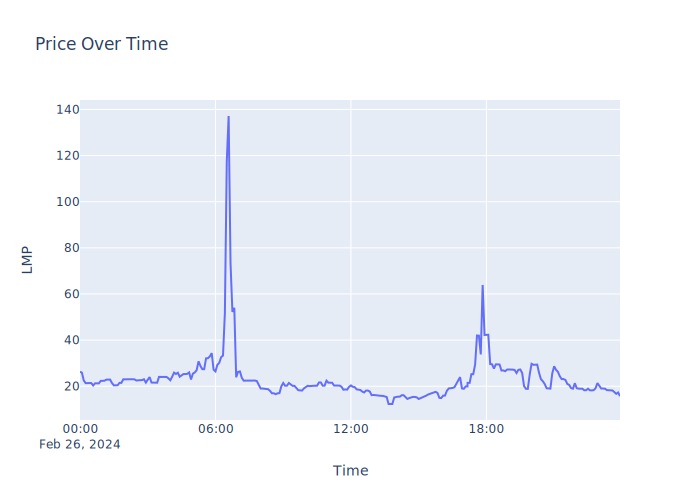

In [10]:
import gridstatus
from chart_utils import show_line_chart


def get_nyiso_price_data_by_location(date, location):
    nyiso = gridstatus.NYISO()
    lmp = nyiso.get_lmp(date=date, market="REAL_TIME_5_MIN")
    lmp_col_subset = lmp[["Time", "Location", "LMP"]]
    lmp_subset_filtered = lmp_col_subset[lmp_col_subset["Location"] == location]
    return lmp_subset_filtered

price_data_by_location = get_nyiso_price_data_by_location("February 26, 2024", "GENESE");
show_line_chart(price_data_by_location, "Time", "LMP", "Price Over Time")

## Average price in one-hour chunks

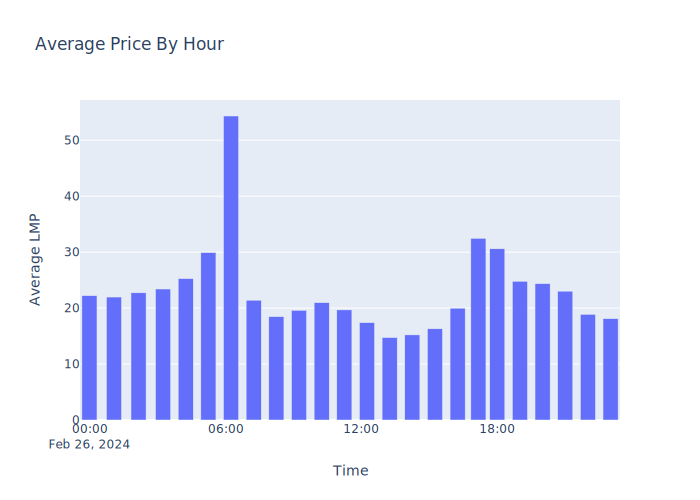

In [11]:
import numpy as np
from chart_utils import show_bar_chart
from chart_utils import get_average_in_column

def get_data_averaged_by_hour(data_by_location, column_to_average):
    data_averaged_by_hour = [];
    num_chunks = len(data_by_location) / 12 # 12 represents number of 5 minute chunks in an hour, our intervals in data
    for chunk in np.array_split(data_by_location, num_chunks):
        data_averaged_by_hour.append([chunk["Time"].iloc[0], get_average_in_column(chunk, column_to_average)])
    return data_averaged_by_hour

price_data_averaged_by_hour = get_data_averaged_by_hour(price_data_by_location, "LMP")
show_bar_chart(price_data_averaged_by_hour, "Time", "Average LMP", "Average Price By Hour")

## Allocate resources by priority, to windows of time with lowest price
**Note**: In this simple implementation we do not consider that the resources could be allocated in parallel

We can see that the windows with highest price remain unallocated to our resources.

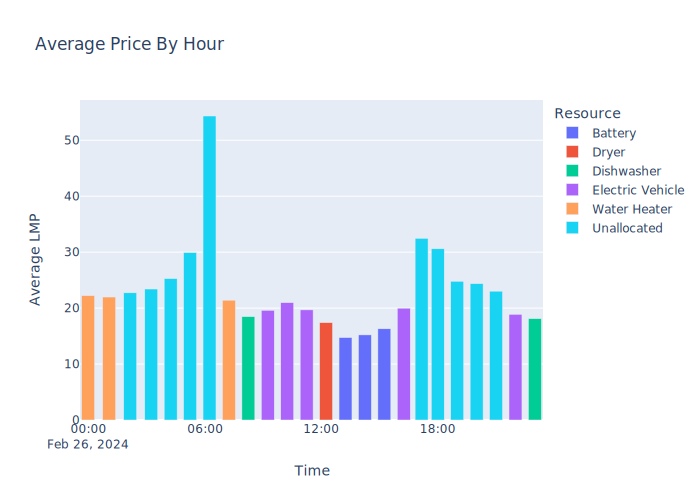

In [12]:
from operator import itemgetter
from allocator import allocate_resources
from chart_utils import show_bar_chart_with_color

def get_resources():
    return [
        {"name": "Battery", "hours": 3, "priority": 1},
        {"name": "Dryer", "hours": 1, "priority": 2},
        {"name": "Dishwasher", "hours": 2, "priority": 3},
        {"name": "Electric Vehicle", "hours": 5, "priority": 4},
        {"name": "Water Heater", "hours": 3, "priority": 5},
    ]

def allocate_resources_by_price(resources, price_data_averaged_by_hour):
    # allocate our resources to windows with lowest price
    price_data_averaged_by_hour_sorted = sorted(price_data_averaged_by_hour, key=itemgetter(1))
    return allocate_resources(resources, price_data_averaged_by_hour_sorted)

resources = get_resources()
price_data_with_resources_allocated = allocate_resources_by_price(resources, price_data_averaged_by_hour)
show_bar_chart_with_color(price_data_with_resources_allocated, 
                          "Resource", "Time", 
                          "Average LMP", 
                          "Average Price By Hour")

## Get data for NYISO "Other Renewables" Output (MW)
According to NYISO Real-Time Dashboard, Other Renewables consists of: Solar Energy, Energy Storage Resources, Methane, Refuse, Wood

To approach Saul Griffith's chart of aligning loads with midday abundance of energy, I use data from the above energy mix output to allocate flexible resources. 

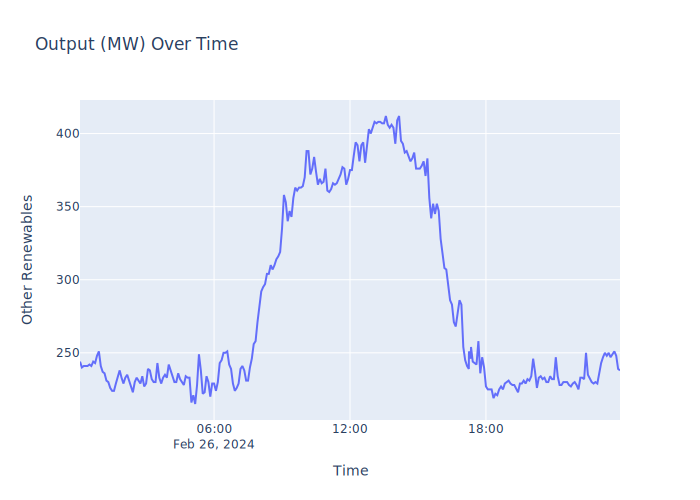

In [13]:
def get_other_renewable_energy_output():
    nyiso = gridstatus.NYISO()
    energy_output = nyiso.get_fuel_mix(start="February 26, 2024", end="February 27, 2024")
    energy_output_col_subset = energy_output[["Time", "Other Renewables"]]
    energy_output_filtered = energy_output_col_subset[energy_output_col_subset["Time"] < "February 27, 2024"]
    return energy_output_filtered
    
other_renewable_energy_output = get_other_renewable_energy_output()
show_line_chart(other_renewable_energy_output, "Time", "Other Renewables", "Output (MW) Over Time")

## Average output MW in one-hour chunks

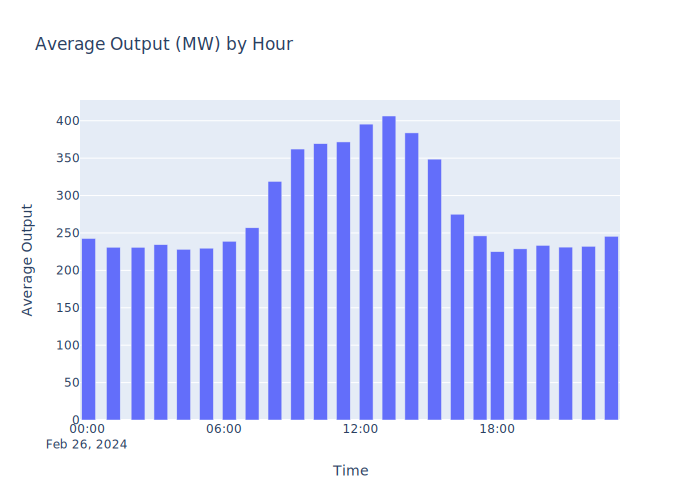

In [14]:
energy_output_averaged_by_hour = get_data_averaged_by_hour(other_renewable_energy_output, "Other Renewables")
show_bar_chart(energy_output_averaged_by_hour, "Time", "Average Output", "Average Output (MW) by Hour")

## Allocate resources by priority, to windows of time with most energy output

We sort the output of energy in descending order, so we can prioritize allocating to windows of time with most energy output

**Note**: In this simple implementation we do not consider that the resources could be allocated in parallel

We can see that the windows with lowest energy output unallocated to our resources.

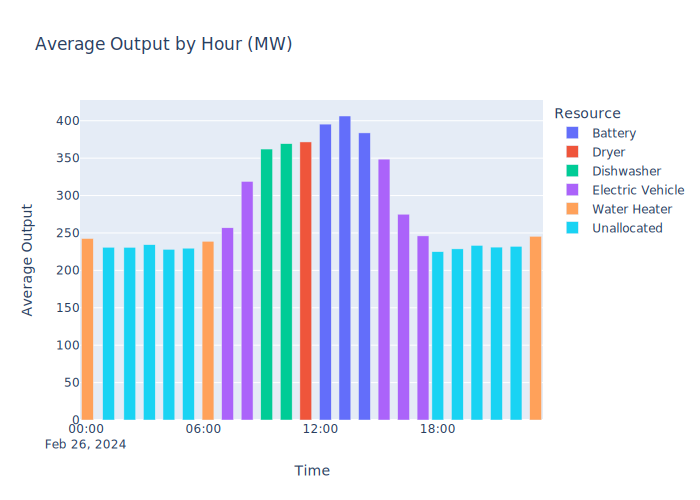

In [15]:
def allocate_resources_by_energy_output(resources, energy_output_averaged_by_hour):
    energy_output_averaged_by_hour_sorted = sorted(energy_output_averaged_by_hour, key=itemgetter(1), reverse=True)
    return allocate_resources(resources, energy_output_averaged_by_hour_sorted)

renewable_data_with_resources_allocated = allocate_resources_by_energy_output(resources, energy_output_averaged_by_hour)
show_bar_chart_with_color(renewable_data_with_resources_allocated, 
                          "Resource", 
                          "Time", 
                          "Average Output", 
                          "Average Output by Hour (MW)")

## Limitations / Questions
* That loads can in practice be scheduled in parallel is not taken into account
* The amount of energy that given load may need is not taken into account
* allocating loads can be done by price or by energy output, can it be assumed that price will always be low when energy output is highest?
* How does energy allocation look on the day itself when values are not yet known? We can use a mix of current data and prediction based on historical data?

### References: 
1. https://medium.com/@si.a.arkin/my-experiences-of-pulling-historical-energy-price-data-via-gridstatus-2cf96e7a7505
2. https://github.com/kmax12/gridstatus
3. https://www.nyiso.com/real-time-dashboard